<a href="https://colab.research.google.com/github/maimonahST/Signal_It/blob/main/Stacking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.base import clone
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, concatenate, Dense, MaxPooling1D, Flatten, GRU, SimpleRNN, LSTM, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential

In [89]:
from sklearn.model_selection import GroupKFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
import numpy as np

gkf=GroupKFold()
class StandardScaler3D(BaseEstimator,TransformerMixin):
    #batch, sequence, channels
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self,X,y=None):
        self.scaler.fit(X.reshape(-1, X.shape[2]))
        return self

    def transform(self,X):
        return self.scaler.transform(X.reshape( -1,X.shape[2])).reshape(X.shape)

In [90]:
def two_splits(data_array , label_array, group_array):

  # Split data_array into train and validate
  train_groups = []
  for train_index, test_index in gkf.split(data_array, label_array, groups=group_array):
      X_train, y_train = data_array[train_index],label_array[train_index]
      X_test, y_test =data_array[test_index],label_array[test_index]
      train_groups = group_array[train_index]

      scaler=StandardScaler3D()
      X_train=scaler.fit_transform(X_train)
      X_test=scaler.transform(X_test)

      print(f"group={np.unique(group_array[train_index])}")
      print(f"group={np.unique(group_array[test_index])}")
      break

  return X_train, X_test, y_train, y_test, train_groups

In [91]:
def block(input):
    conv1 = Conv1D(32, 2, strides=2, activation='relu', padding="same")(input)
    conv2 = Conv1D(32, 4, strides=2, activation='relu', padding="causal")(input)
    conv3 = Conv1D(32, 8, strides=2, activation='relu', padding="causal")(input)
    x = concatenate([conv1, conv2, conv3], axis=2)
    return x

In [92]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns



def fit_and_evaluate(X_train, y_train, X_test, y_test,model):

  model.fit(X_train, y_train)

  # Predictions on the test set
  y_pred = model.predict(X_test)

  # Calculate evaluation metrics
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average='weighted')
  f1 = f1_score(y_test, y_pred, average='weighted')


  # Print the results
  print("Accuracy:", accuracy)
  print("Recall:", recall)
  print("Precision:", precision)
  print("F1-score:", f1)


  print("Classification Report (Test):\n", classification_report(y_test, y_pred))

  # Compute the confusion matrix for the test set
  cm_test = confusion_matrix(y_test, y_pred)

  # Plot the confusion matrix for the test set
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title(f"Confusion Matrix for Decision Tree {model.__class__}")
  plt.show()

  return model




def evaluate(model, X_test, y_test):

  # Predictions on the test set
  y_pred = model.predict(X_test)
  y_pred = (y_pred > 0.5).astype(int)

  # Calculate evaluation metrics
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average='weighted')
  f1 = f1_score(y_test, y_pred, average='weighted')


  # Print the results
  print("Accuracy:", accuracy)
  print("Recall:", recall)
  print("Precision:", precision)
  print("F1-score:", f1)


  print("Classification Report (Test):\n", classification_report(y_test, y_pred))

  # Compute the confusion matrix for the test set
  cm_test = confusion_matrix(y_test, y_pred)

  # Plot the confusion matrix for the test set
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title(f"Confusion Matrix for Decision Tree {model.__class__}")
  plt.show()

  return



def plot_history(hist):
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

# ICA

**Prepare the data**


In [25]:
from sklearn.model_selection import train_test_split
import numpy as np


# Step 1: Load the data
X = np.load('/content/drive/MyDrive/GP/GP-Data/X_ica2.npy')
y = np.load('/content/drive/MyDrive/GP/GP-Data/y_ica2.npy')

y = y.astype('int')

print(X.shape, y.shape)

# Step 2: Convert multicalss to binary
y[y==0] = 1 #Stroke
y[y==2] = 0 #Healthy


# Step 3: Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)



(45, 32, 32) (45,)


In [26]:
# Flatten the data array for ML models
X_train_ica_ml = X_train.reshape(X_train.shape[0], -1)
X_test_ica_ml = X_test.reshape(X_test.shape[0], -1)
y_train_ica_ml = y_train.reshape(y_train.shape[0], -1)
y_test_ica_ml = y_test.reshape(y_test.shape[0], -1)


##  Train Indivedual Models

Ensemble ML models (Bernoulli NB, Adaboost, XGBoost, DT) using several ensemble methods

### ML

In [27]:
# Train ML models (Base models)
bernoulli_nb = BernoulliNB(alpha=0.1, binarize = 0.0 , fit_prior = True)
bernoulli_nb.fit(X_train_ica_ml, y_train)

BernoulliNB(alpha=0.1)

In [28]:
Adaboost = AdaBoostClassifier(n_estimators = 200 , learning_rate = 1)
Adaboost.fit(X_train_ica_ml, y_train)

AdaBoostClassifier(learning_rate=1, n_estimators=200)

In [29]:
xgboost = XGBClassifier(max_depth=9, n_estimators=200, learning_rate=0.01)
xgboost.fit(X_train_ica_ml, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [30]:
decision_tree = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=5)
decision_tree.fit(X_train_ica_ml, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=5)

In [31]:
RandomForest = RandomForestClassifier(n_estimators=100, max_depth=3, min_samples_leaf=5)
RandomForest.fit(X_train_ica_ml, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=5)

### DL

In [32]:
X_train_dl, X_val, y_train_dl, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train_dl.shape, X_val.shape, y_train_dl.shape, y_test.shape

((28, 32, 32), (8, 32, 32), (28,), (9,))

In [33]:
scalar = StandardScaler3D()

X_train_dl = scalar.fit_transform(X_train_dl)
X_val = scalar.transform(X_val)
X_test_dl = scalar.transform(X_test)


#### CNN

Epoch 1/70
1/1 [==============================] - 3s 3s/step - loss: 0.7064 - accuracy: 0.4643 - val_loss: 0.7417 - val_accuracy: 0.3750
Epoch 2/70
1/1 [==============================] - 0s 42ms/step - loss: 0.5624 - accuracy: 0.8571 - val_loss: 0.7913 - val_accuracy: 0.3750
Epoch 3/70
1/1 [==============================] - 0s 42ms/step - loss: 0.4746 - accuracy: 0.8929 - val_loss: 0.8347 - val_accuracy: 0.3750
Epoch 4/70
1/1 [==============================] - 0s 44ms/step - loss: 0.4019 - accuracy: 0.9286 - val_loss: 0.8575 - val_accuracy: 0.3750
Epoch 5/70
1/1 [==============================] - 0s 45ms/step - loss: 0.3347 - accuracy: 1.0000 - val_loss: 0.8876 - val_accuracy: 0.3750
Epoch 6/70
1/1 [==============================] - 0s 213ms/step
Accuracy: 0.7777777777777778
Recall: 0.7777777777777778
Precision: 0.8333333333333334
F1-score: 0.738095238095238
Classification Report (Test):
               precision    recall  f1-score   support

           0       1.00      0.33      0.50

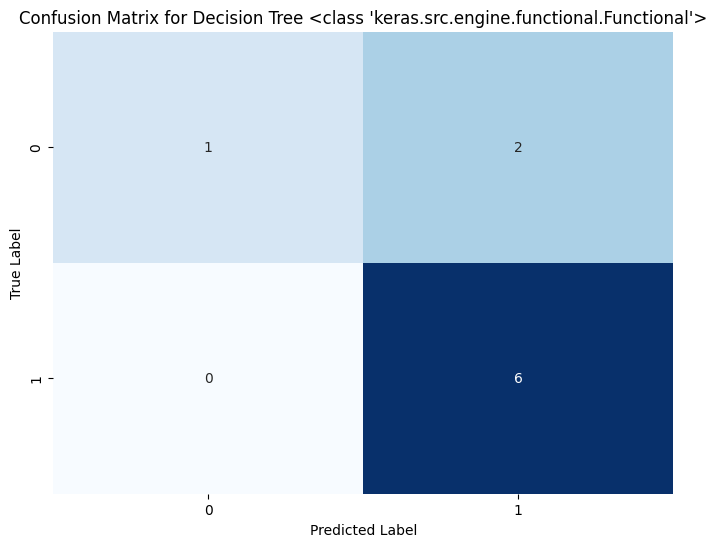

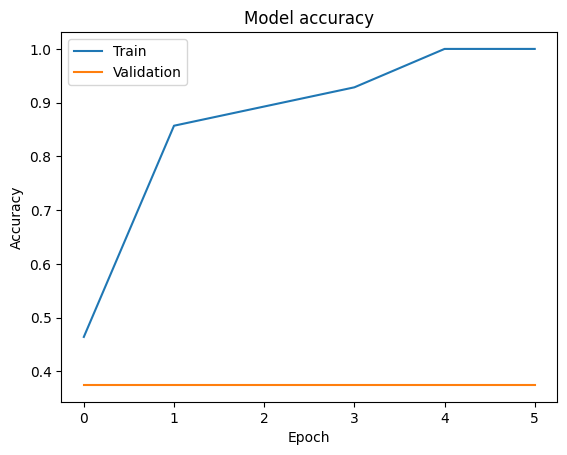

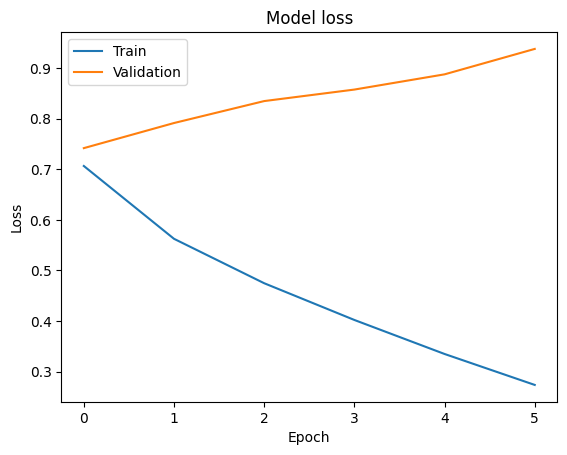

In [34]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import EarlyStopping

def block(input):
    conv1 = Conv1D(32, 2, strides=2, activation='relu', padding="same")(input)
    conv2 = Conv1D(32, 4, strides=2, activation='relu', padding="causal")(input)
    conv3 = Conv1D(32, 8, strides=2, activation='relu', padding="causal")(input)
    x = concatenate([conv1, conv2, conv3], axis=2)
    return x

# Define the input layer with a shape of (32, 32)
input_layer = Input(shape=(32, 32))

# Create the first block
block1 = block(input_layer)

# Create the second block using the 'block' function with the output of the first block as input
block2 = block(block1)

# Create the third block using the 'block' function with the output of the second block as input
block3 = block(block2)

cnn_out1 = Conv1D(32, 3, activation='relu', padding='same')(block3)
cnn_out2 = Conv1D(32, 3, activation='relu', padding='same')(cnn_out1)
cnn_out3 = MaxPooling1D(pool_size=2)(cnn_out2)
cnn_out4 = Flatten()(cnn_out3)

# Create a Dense layer with 1 unit and sigmoid activation for binary classification
predictions = Dense(1, activation='sigmoid')(cnn_out4)

# Define the model with 'input_layer' as the input and 'predictions' as the output
cnn_model = Model(inputs=input_layer, outputs=predictions)

# Specify the Adam optimizer with a learning rate of 0.0001
optimizer = Adam(learning_rate=0.001)

# Compile the model with binary crossentropy loss and accuracy as the evaluation metric
cnn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model using training features and labels
hist = cnn_model.fit(X_train_dl, y_train_dl, epochs=70, batch_size=64,
                 validation_data=(X_val, y_val), callbacks=[early_stopping])

# evaluate the model
evaluate(cnn_model,  X_test_dl, y_test)


# plot model accuracy and loss of training and validation
plot_history(hist)

#### LSTM

Epoch 1/30
3/3 [==============================] - 5s 498ms/step - loss: 0.6978 - accuracy: 0.4286 - val_loss: 0.6968 - val_accuracy: 0.5000
Epoch 2/30
3/3 [==============================] - 0s 42ms/step - loss: 0.6810 - accuracy: 0.6429 - val_loss: 0.7024 - val_accuracy: 0.5000
Epoch 3/30
3/3 [==============================] - 0s 42ms/step - loss: 0.6691 - accuracy: 0.6786 - val_loss: 0.7079 - val_accuracy: 0.5000
Epoch 4/30
3/3 [==============================] - 0s 45ms/step - loss: 0.6647 - accuracy: 0.6429 - val_loss: 0.7135 - val_accuracy: 0.5000
Epoch 5/30
3/3 [==============================] - 0s 41ms/step - loss: 0.6454 - accuracy: 0.6786 - val_loss: 0.7210 - val_accuracy: 0.5000
Epoch 6/30
1/1 [==============================] - 1s 756ms/step
Accuracy: 0.8888888888888888
Recall: 0.8888888888888888
Precision: 0.9047619047619047
F1-score: 0.882051282051282
Classification Report (Test):
               precision    recall  f1-score   support

           0       1.00      0.67      0

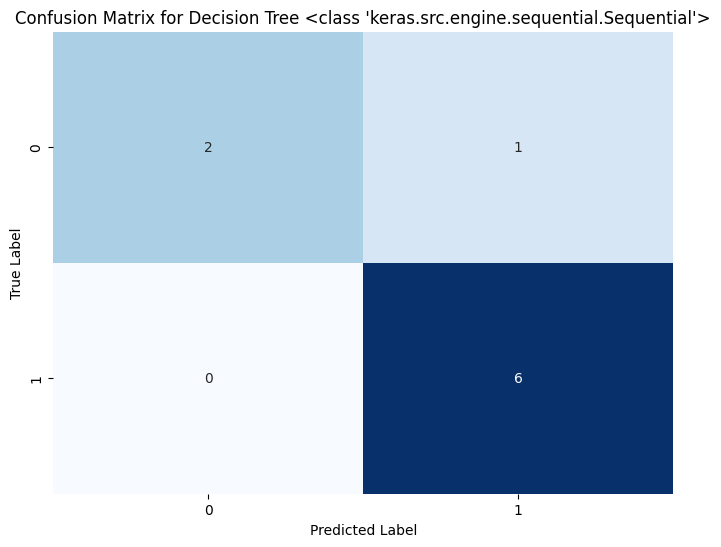

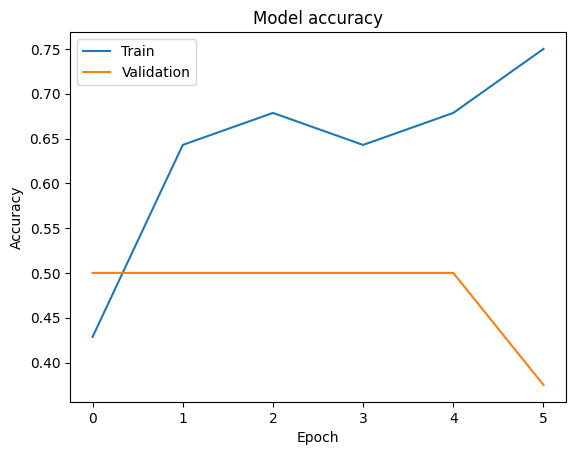

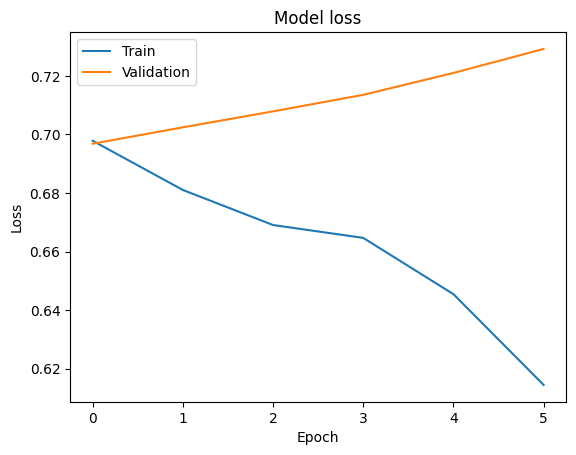

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

lstm_model = Sequential()
lstm_model.add(LSTM(units = 50, return_sequences = True, input_shape = (32, 32)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units = 25))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units = 1, activation = 'sigmoid'))
optimizer = Adam(learning_rate=0.001)
lstm_model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

hist = lstm_model.fit(X_train_dl, y_train_dl, epochs=30, batch_size=10, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate the model
evaluate(lstm_model, X_test_dl, y_test)

# Plot the history
plot_history(hist)

#### CNN+LSTM

Epoch 1/70
1/1 [==============================] - 4s 4s/step - loss: 0.6921 - accuracy: 0.4286 - val_loss: 0.6982 - val_accuracy: 0.3750
Epoch 2/70
1/1 [==============================] - 0s 48ms/step - loss: 0.6494 - accuracy: 0.7500 - val_loss: 0.7372 - val_accuracy: 0.3750
Epoch 3/70
1/1 [==============================] - 0s 49ms/step - loss: 0.6227 - accuracy: 0.6429 - val_loss: 0.7635 - val_accuracy: 0.3750
Epoch 4/70
1/1 [==============================] - 0s 50ms/step - loss: 0.5994 - accuracy: 0.6429 - val_loss: 0.7703 - val_accuracy: 0.3750
Epoch 5/70
1/1 [==============================] - 0s 47ms/step - loss: 0.5706 - accuracy: 0.6429 - val_loss: 0.7604 - val_accuracy: 0.3750
Epoch 6/70
1/1 [==============================] - 0s 494ms/step
Accuracy: 0.7777777777777778
Recall: 0.7777777777777778
Precision: 0.8333333333333334
F1-score: 0.738095238095238
Classification Report (Test):
               precision    recall  f1-score   support

           0       1.00      0.33      0.50

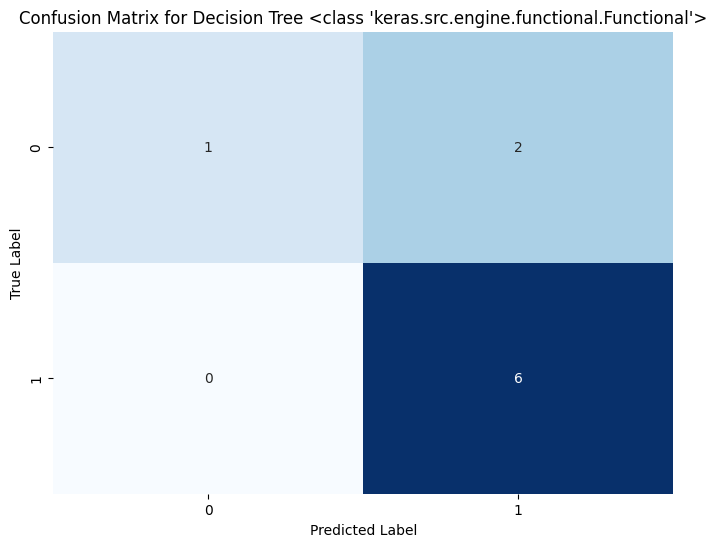

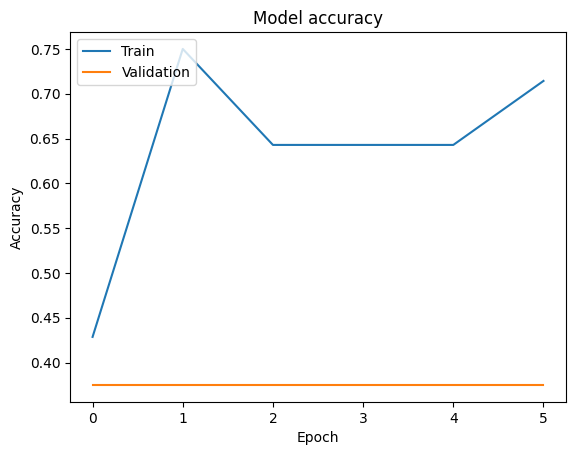

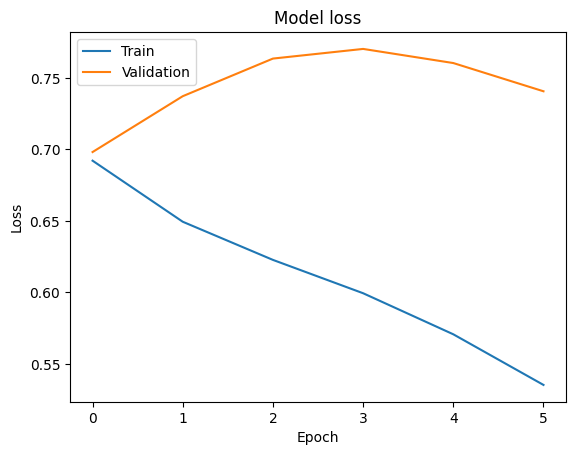

In [37]:
from tensorflow.keras.layers import Input, Conv1D, concatenate, Dense, MaxPooling1D, Flatten, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping

# Define the input layer with a shape of (32, 32)
input_layer = Input(shape=(32, 32))

# Convolutional Block
conv1 = Conv1D(32, 2, strides=2, activation='relu', padding="same")(input_layer)
conv2 = Conv1D(32, 4, strides=2, activation='relu', padding="causal")(input_layer)
conv3 = Conv1D(32, 8, strides=2, activation='relu', padding="causal")(input_layer)
cnn_output = concatenate([conv1, conv2, conv3], axis=2)

# LSTM Layer
lstm_layer = LSTM(50)(cnn_output)

# Fully Connected Layers
dense1 = Dense(32, activation='tanh')(lstm_layer)

# Output Layer
predictions = Dense(1, activation='sigmoid')(dense1)

# Create the model
cnnlstm_model = Model(inputs=input_layer, outputs=predictions)

# Compile the model
optimizer = Adam(learning_rate=0.001)
cnnlstm_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


hist = cnnlstm_model.fit(X_train_dl, y_train_dl, epochs=70,
                 batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate the model
evaluate(cnnlstm_model,X_test_dl, y_test)

# Plot the history
plot_history(hist)

#### CNN+GRU

Epoch 1/70
1/1 [==============================] - 11s 11s/step - loss: 0.7636 - accuracy: 0.3929 - val_loss: 0.7225 - val_accuracy: 0.3750
Epoch 2/70
1/1 [==============================] - 0s 56ms/step - loss: 0.6408 - accuracy: 0.6786 - val_loss: 0.8231 - val_accuracy: 0.3750
Epoch 3/70
1/1 [==============================] - 0s 64ms/step - loss: 0.6053 - accuracy: 0.6071 - val_loss: 0.8901 - val_accuracy: 0.3750
Epoch 4/70
1/1 [==============================] - 0s 61ms/step - loss: 0.5767 - accuracy: 0.6071 - val_loss: 0.9058 - val_accuracy: 0.3750
Epoch 5/70
1/1 [==============================] - 0s 57ms/step - loss: 0.5232 - accuracy: 0.6071 - val_loss: 0.8829 - val_accuracy: 0.3750
Epoch 6/70
1/1 [==============================] - 2s 2s/step
Accuracy: 0.7777777777777778
Recall: 0.7777777777777778
Precision: 0.7777777777777778
F1-score: 0.7777777777777778
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.67      0.67      0.67

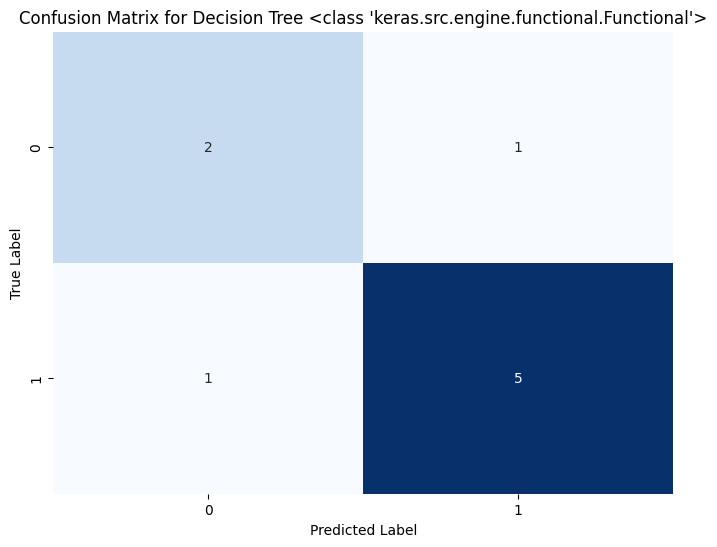

In [39]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#resource:https://github.com/dll-ncai/eeg_pre-diagnostic_screening/blob/master/code/chrononet/chrono.py

def block(input):

  """
    Create a block consisting of three parallel convolutional layers followed by concatenation.

    Parameters:
    - input: Input tensor.

    Returns:
    - Concatenated tensor resulting from the parallel convolutional layers.
    """

  conv1 = Conv1D(32, 2, strides=2,activation='relu',padding="same")(input)
  conv2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(input)
  conv3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(input)
  x = concatenate([conv1,conv2,conv3],axis=2)
  return x

# Define the input layer with a shape of (32, 32)
input = Input(shape=(32, 32))

# Create the first block
block1 = block(input)

# Create the second block using the 'block' function with the output of the first block as input
block2 = block(block1)

# Create the third block using the 'block' function with the output of the second block as input
block3 = block(block2)

gru_out1 = GRU(32,activation='tanh',return_sequences=True)(block3)
gru_out2 = GRU(32,activation='tanh',return_sequences=True)(gru_out1)
gru_out = concatenate([gru_out1,gru_out2],axis=2)
gru_out3 = GRU(32,activation='tanh',return_sequences=True)(gru_out)
gru_out = concatenate([gru_out1,gru_out2,gru_out3])
gru_out4 = GRU(32,activation='tanh')(gru_out)

# Create a Dense layer with 1 unit and sigmoid activation for binary classification
predictions = Dense(1, activation='sigmoid')(gru_out4)

# Define the model with 'input' as the input and 'predictions' as the output
CNNGRU_model = Model(inputs=input, outputs=predictions)

# Specify the Adam optimizer with a learning rate of 0.0001
optimizer = Adam(learning_rate=0.001)

# Compile the model with binary crossentropy loss and accuracy as the evaluation metric
CNNGRU_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

hist = CNNGRU_model.fit(X_train_dl, y_train_dl, epochs = 70, batch_size = 32,
                 validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate the model
evaluate(CNNGRU_model, X_test_dl, y_test)

# Plot the history
# plot_history(hist)

#### RNN

Epoch 1/70
1/1 [==============================] - 2s 2s/step - loss: 0.7003 - accuracy: 0.5714 - val_loss: 0.6480 - val_accuracy: 0.5000
Epoch 2/70
1/1 [==============================] - 0s 55ms/step - loss: 0.4563 - accuracy: 0.8571 - val_loss: 0.6498 - val_accuracy: 0.6250
Epoch 3/70
1/1 [==============================] - 0s 52ms/step - loss: 0.3135 - accuracy: 1.0000 - val_loss: 0.6526 - val_accuracy: 0.6250
Epoch 4/70
1/1 [==============================] - 0s 257ms/step
Accuracy: 0.3333333333333333
Recall: 0.3333333333333333
Precision: 0.4
F1-score: 0.35000000000000003
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.20      0.33      0.25         3
           1       0.50      0.33      0.40         6

    accuracy                           0.33         9
   macro avg       0.35      0.33      0.33         9
weighted avg       0.40      0.33      0.35         9



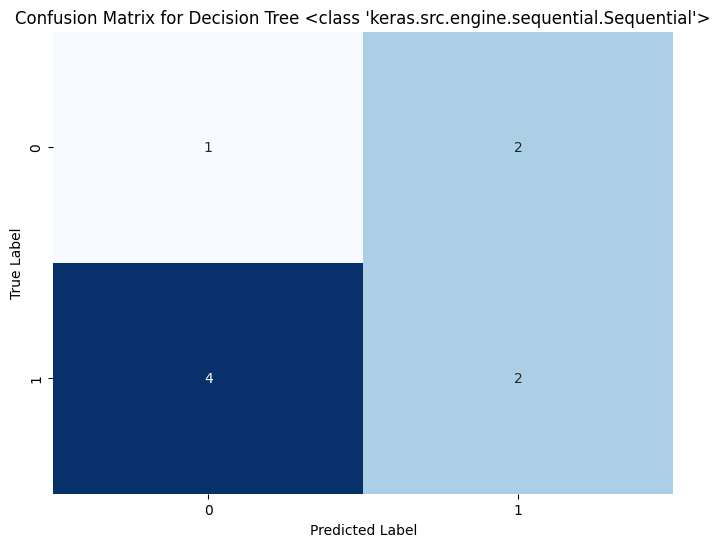

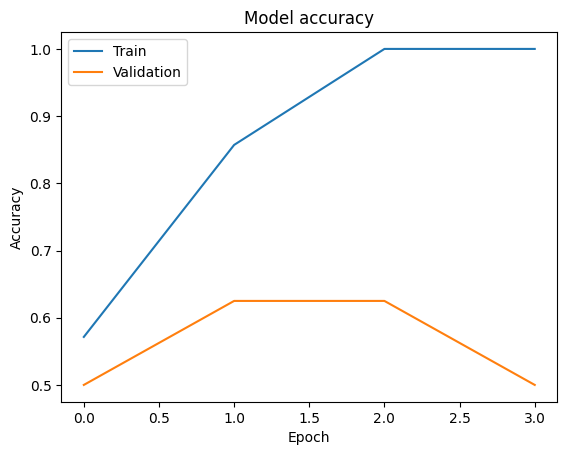

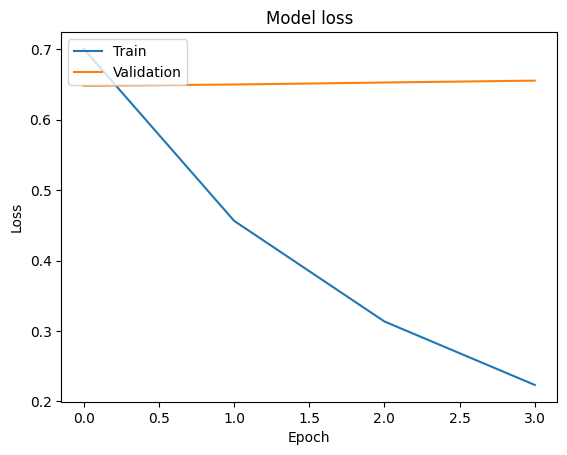

In [49]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

input_shape = (32, 32)  # Define input shape as a tuple

def create_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(128, input_shape=input_shape, return_sequences=True))  # RNN layer with 128 units and return sequences
    model.add(SimpleRNN(128))  # Additional RNN layer with 128 units
    model.add(Dense(64, activation='relu'))  # Dense layer with 64 units and ReLU activation
    model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation

    return model

# Pass input shape tuple to the create_model function
rnn_model = create_model(input_shape)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
rnn_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

hist = rnn_model.fit(X_train_dl, y_train_dl, epochs=70, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate the model
evaluate(rnn_model, X_test_dl, y_test)

# Plot the history
plot_history(hist)

### Voting

In [56]:
# 4. Generate predictions
bernoulli_nb_predictions_ica = bernoulli_nb.predict(X_test_ica_ml).reshape(-1, 1)
dt_predictions_ica = decision_tree.predict(X_test_ica_ml).reshape(-1, 1)
xgboost_predictions_ica = xgboost.predict(X_test_ica_ml).reshape(-1, 1)
RandomForest_predictions_ica= RandomForest.predict(X_test_ica_ml).reshape(-1, 1)
Adaboost_predictions_ica = Adaboost.predict(X_test_ica_ml).reshape(-1, 1)

cnn_model_predictions_ica = cnn_model.predict(X_test_dl).reshape(-1, 1)
lstm_model_predictions_ica = lstm_model.predict(X_test_dl).reshape(-1, 1)
cnnlstm_model_predictions_ica = cnnlstm_model.predict(X_test_dl).reshape(-1, 1)
cnngru_model_predictions_ica = CNNGRU_model.predict(X_test_dl).reshape(-1, 1)
rnn_model_predictions_ica = rnn_model.predict(X_test_dl).reshape(-1, 1)


bernoulli_nb_predictions_ica.shape , dt_predictions_ica.shape , xgboost_predictions_ica.shape, RandomForest_predictions_ica.shape

1/1 [==============================] - 0s 27ms/step


((9, 1), (9, 1), (9, 1), (9, 1))

In [70]:
# bernoulli_nb_predictions, xgboost_predictions,dt_predictions,RandomForest_predictions
from scipy.stats import mode

threshold = 0.5
bernoulli_nb_predictions_ica = (bernoulli_nb_predictions_ica >= threshold).astype(int)
dt_predictions_ica =  (dt_predictions_ica >= threshold).astype(int)
xgboost_predictions_ica =  (xgboost_predictions_ica >= threshold).astype(int)
Adaboost_predictions_ica =  (Adaboost_predictions_ica >= threshold).astype(int)

cnn_model_predictions_ica =  (cnn_model_predictions_ica >= threshold).astype(int)
lstm_model_predictions_ica =  (lstm_model_predictions_ica >= threshold).astype(int)
cnnlstm_model_predictions_ica =  (cnnlstm_model_predictions_ica >= threshold).astype(int)
cnngru_model_predictions_ica =  (cnngru_model_predictions_ica >= threshold).astype(int)
rnn_model_predictions_ica =  (rnn_model_predictions_ica >= threshold).astype(int)



ensemble_list_ica = [xgboost_predictions_ica,
                    dt_predictions_ica,
                    cnn_model_predictions_ica,
                    lstm_model_predictions_ica,
                    cnnlstm_model_predictions_ica,
                    cnngru_model_predictions_ica]

# Combine predictions
ensemble_voting_ica = mode(ensemble_list_ica, axis=0)[0].squeeze()


# Compute accuracy using the binary class labels
ensemble_accuracy_ica = accuracy_score(y_test, ensemble_voting_ica)
precision_ica = precision_score(y_test, ensemble_voting_ica)
recall_ica = recall_score(y_test, ensemble_voting_ica)
f1_ica = f1_score(y_test, ensemble_voting_ica)

print(f'Ensemble accuracy : {ensemble_accuracy_ica}')
print(f'Ensemble precision : {precision_ica}')
print(f'Ensemble recall : {recall_ica}')
print(f'Ensemble f1 : {f1_ica}')


Ensemble accuracy : 0.8888888888888888
Ensemble precision : 0.8571428571428571
Ensemble recall : 1.0
Ensemble f1 : 0.923076923076923


### Stacking

In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb


bernoulli_nb_train = bernoulli_nb.predict(X_train_ica_ml).reshape(-1, 1)
dt_train = decision_tree.predict(X_train_ica_ml).reshape(-1, 1)
xgboost_train = xgboost.predict(X_train_ica_ml).reshape(-1, 1)
RandomForest_train= RandomForest.predict(X_train_ica_ml).reshape(-1, 1)
Adaboost_train = Adaboost.predict(X_train_ica_ml).reshape(-1, 1)

cnn_model_train = cnn_model.predict(X_train).reshape(-1, 1)
lstm_model_train = lstm_model.predict(X_train).reshape(-1, 1)
cnnlstm_model_train = cnnlstm_model.predict(X_train).reshape(-1, 1)
cnngru_model_train = CNNGRU_model.predict(X_train).reshape(-1, 1)
rnn_model_train = rnn_model.predict(X_train).reshape(-1, 1)

# lstm_model_train,
#                                cnnlstm_model_train,
#                                cnngru_model_train,
#                                rnn_model_train
#making a new dataset for training our final model by stacking the predictions on the validation data
train_stack = np.column_stack((dt_train,
                               xgboost_train,
                               cnn_model_train,
                               lstm_model_train,
                               cnnlstm_model_train,
                               cnngru_model_train))


# lstm_model_train,
#                                cnnlstm_model_train,
#                                cnngru_model_train,
#                                rnn_model_train

#making the final test set for our final model by stacking the predictions on the test data
test_stack = np.column_stack((dt_predictions_ica,
                              xgboost_predictions_ica,
                              cnn_model_predictions_ica,
                              lstm_model_predictions_ica,
                              cnnlstm_model_predictions_ica,
                              cnngru_model_predictions_ica))

final_model = LogisticRegression()


#training the final model on the stacked predictions
final_model.fit(train_stack,y_train)

final_predictions = final_model.predict(test_stack)

# Compute accuracy using the binary class labels
ensemble_accuracy_ica = accuracy_score(y_test, final_predictions)
precision_ica = precision_score(y_test, final_predictions)
recall_ica = recall_score(y_test, final_predictions)
f1_ica = f1_score(y_test, final_predictions)

print(f'Ensemble accuracy : {ensemble_accuracy_ica}')
print(f'Ensemble precision : {precision_ica}')
print(f'Ensemble recall : {recall_ica}')
print(f'Ensemble f1 : {f1_ica}')

2/2 [==============================] - 0s 9ms/step
Ensemble accuracy : 0.8888888888888888
Ensemble precision : 0.8571428571428571
Ensemble recall : 1.0
Ensemble f1 : 0.923076923076923


# Epochs

In [ ]:
data_array = np.load('/content/drive/MyDrive/GP/GP-Data/data_array.npy')
label_array = np.load('/content/drive/MyDrive/GP/GP-Data/label_array.npy')
group_array = np.load('/content/drive/MyDrive/GP/GP-Data/group_array.npy')

label_array = label_array.astype('int')

data_array.shape, label_array.shape, group_array.shape

((7150, 1250, 33), (7150,), (7150,))

In [ ]:
np.unique(label_array)

array([0, 1, 2])

In [ ]:
# Load your dataset and split into training and testing sets
X_train, X_test, y_train, y_test, _= two_splits(data_array, label_array, group_array)


y_train[y_train==0] = 1 #Stroke
y_train[y_train==2] = 0 #Healthy

y_test[y_test==0] = 1 #Stroke
y_test[y_test==2] = 0 #Healthy


group=[ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 18 19 20 22 23 25 27 28 29
 30 31 34 36 37 38 39 40 41 42 43 44 45 46 47]
group=[ 9 14 17 21 24 26 32 33 35]


In [ ]:
np.unique(y_train), np.unique(y_test)

(array([0, 1]), array([0, 1]))

In [ ]:
# Flatten the data array for ML models
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
# y_train = y_train.reshape(y_train.shape[0], -1)
# y_test = y_test.reshape(y_test.shape[0], -1)

In [ ]:
# Train ML models (Base models)
bernoulli_nb = BernoulliNB(alpha=0.1, binarize = 0.0 , fit_prior = True)
bernoulli_nb.fit(X_train, y_train)

BernoulliNB(alpha=0.1)

In [ ]:
Adaboost = AdaBoostClassifier(n_estimators = 200 , learning_rate = 1)
Adaboost.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=1, n_estimators=200)

In [ ]:
xgboost = XGBClassifier(max_depth=9, n_estimators=200, learning_rate=0.01)
xgboost.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
decision_tree = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=5)
decision_tree.fit(X_train, y_train)

In [ ]:
RandomForest = RandomForestClassifier(n_estimators=100, max_depth=3, min_samples_leaf=5)
RandomForest.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=5)

In [ ]:
# 4. Generate predictions
bernoulli_nb_predictions_train  = bernoulli_nb.predict(X_train).reshape(-1, 1)
dt_predictions_train            = decision_tree.predict(X_train).reshape(-1, 1)
xgboost_predictions_train       = xgboost.predict(X_train).reshape(-1, 1)
RandomForest_predictions_train  = RandomForest.predict(X_train).reshape(-1, 1)
Adaboost_predictions_train      = Adaboost.predict(X_train).reshape(-1, 1)


bernoulli_nb_predictions_test   = bernoulli_nb.predict(X_test).reshape(-1, 1)
dt_predictions_test             = decision_tree.predict(X_test).reshape(-1, 1)
xgboost_predictions_test        = xgboost.predict(X_test).reshape(-1, 1)
RandomForest_predictions_test   = RandomForest.predict(X_test).reshape(-1, 1)
Adaboost_predictions_test       = Adaboost.predict(X_test).reshape(-1, 1)



### Stacking ML only

In [ ]:
#making a new dataset for training our final model by stacking the predictions on the validation data
train_stack = np.column_stack((bernoulli_nb_predictions_train,
                               xgboost_predictions_train,
                               Adaboost_predictions_train))

#making the final test set for our final model by stacking the predictions on the test data
test_stack = np.column_stack((bernoulli_nb_predictions_test,
                              xgboost_predictions_test,
                              Adaboost_predictions_test))


final_model = RandomForestClassifier()

#training the final model on the stacked predictions
final_model.fit(train_stack,y_train)

final_predictions = final_model.predict(test_stack)

# Compute accuracy using the binary class labels
ensemble_accuracy = accuracy_score(y_test, final_predictions)
precision         = precision_score(y_test, final_predictions)
recall            = recall_score(y_test, final_predictions)
f1                = f1_score(y_test, final_predictions)

print(f'Ensemble accuracy : {ensemble_accuracy}')
print(f'Ensemble precision : {precision}')
print(f'Ensemble recall : {recall}')
print(f'Ensemble f1 : {f1}')

Ensemble accuracy : 0.6854663774403471
Ensemble precision : 0.6881878209831255
Ensemble recall : 0.989451476793249
Ensemble f1 : 0.8117697966248377


## Ensemble DL and ML

In [ ]:
# 1. Preprocess the data for both ML and DL models

# Load your dataset and split into training and testing sets
X_train, X_test, y_train, y_test, train_groups = two_splits(data_array, label_array, group_array)


y_train[y_train==0] = 1 #Stroke
y_train[y_train==2] = 0 #Healthy

y_test[y_test==0] = 1 #Stroke
y_test[y_test==2] = 0 #Healthy

group=[ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 18 19 20 22 23 25 27 28 29
 30 31 34 36 37 38 39 40 41 42 43 44 45 46 47]
group=[ 9 14 17 21 24 26 32 33 35]


In [ ]:
X_train_ml, y_train_ml = X_train.reshape(X_train.shape[0], -1), y_train

In [ ]:
# 2. Train ML models

# bernoulli_nb = BernoulliNB(alpha=0.1, binarize = 0.0 , fit_prior = True))
# bernoulli_nb.fit(X_train_ml, y_train_ml)

decision_tree = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=5)
decision_tree.fit(X_train_ml, y_train_ml)



DecisionTreeClassifier(max_depth=3, min_samples_leaf=5)

In [ ]:
xgboost = XGBClassifier(max_depth=3, n_estimators=200, learning_rate=0.1, random_state=42)
xgboost.fit(X_train_ml, y_train_ml)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
# DL
X_train_dl, X_val_dl, y_train_dl, y_val_dl, _ = two_splits(X_train, y_train, train_groups)

group=[ 0  2  3  5  6  7 10 11 12 13 15 16 18 20 22 23 25 27 28 30 31 34 36 38
 39 40 41 42 43 44 46 47]
group=[ 1  4  8 19 29 37 45]


In [ ]:
X_train_dl.shape, y_train_dl.shape, X_val_dl.shape, y_val_dl.shape

((4728, 1250, 33), (4728,), (1039, 1250, 33), (1039,))

In [ ]:
# 3. Train DL models

# Define the input layer with a shape of (1250, 33)
input_layer = Input(shape=(1250, 33))

# Create the first block
block1 = block(input_layer)

# Create the second block using the 'block' function with the output of the first block as input
block2 = block(block1)

# Create the third block using the 'block' function with the output of the second block as input
block3 = block(block2)

cnn_out1 = Conv1D(32, 3, activation='relu', padding='same')(block3)
cnn_out2 = Conv1D(32, 3, activation='relu', padding='same')(cnn_out1)
cnn_out3 = MaxPooling1D(pool_size=2)(cnn_out2)
cnn_out4 = Flatten()(cnn_out3)

# Create a Dense layer with 1 unit and sigmoid activation for binary classification
predictions = Dense(1, activation='sigmoid')(cnn_out4)

# Define the model with 'input_layer' as the input and 'predictions' as the output
CNN = Model(inputs=input_layer, outputs=predictions)

# Specify the Adam optimizer with a learning rate of 0.0001
optimizer = Adam(learning_rate=0.0001)

# Compile the model with binary crossentropy loss and accuracy as the evaluation metric
CNN.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model using training features and labels
hist = CNN.fit(X_train_dl, y_train_dl, epochs=70, batch_size=132, validation_data= (X_val_dl, y_val_dl), callbacks=[early_stopping])


Epoch 1/70
36/36 [==============================] - 13s 130ms/step - loss: 0.6888 - accuracy: 0.5791 - val_loss: 0.6903 - val_accuracy: 0.5544
Epoch 2/70
36/36 [==============================] - 1s 38ms/step - loss: 0.6650 - accuracy: 0.6036 - val_loss: 0.6893 - val_accuracy: 0.5515
Epoch 3/70
36/36 [==============================] - 1s 38ms/step - loss: 0.6498 - accuracy: 0.6191 - val_loss: 0.6895 - val_accuracy: 0.5563
Epoch 4/70
36/36 [==============================] - 1s 38ms/step - loss: 0.6346 - accuracy: 0.6436 - val_loss: 0.6896 - val_accuracy: 0.5573
Epoch 5/70
36/36 [==============================] - 1s 38ms/step - loss: 0.6186 - accuracy: 0.6548 - val_loss: 0.6878 - val_accuracy: 0.5650
Epoch 6/70
36/36 [==============================] - 1s 38ms/step - loss: 0.5967 - accuracy: 0.6887 - val_loss: 0.6864 - val_accuracy: 0.5659
Epoch 7/70
36/36 [==============================] - 1s 38ms/step - loss: 0.5704 - accuracy: 0.7250 - val_loss: 0.6898 - val_accuracy: 0.5794
Epoch 8/70


In [ ]:
# Define the input layer with a shape of (1250, 33)
input = Input(shape=(1250, 33))

# Create the first block
block1 = block(input)

# Create the second block using the 'block' function with the output of the first block as input
block2 = block(block1)

# Create the third block using the 'block' function with the output of the second block as input
block3 = block(block2)


gru_out1 = GRU(32,activation='tanh',return_sequences=True)(block3)
gru_out2 = GRU(32,activation='tanh',return_sequences=True)(gru_out1)
gru_out = concatenate([gru_out1,gru_out2],axis=2)
gru_out3 = GRU(32,activation='tanh',return_sequences=True)(gru_out)
gru_out = concatenate([gru_out1,gru_out2,gru_out3])
gru_out4 = GRU(32,activation='tanh')(gru_out)


# Create a Dense layer with 1 unit and sigmoid activation for binary classification
predictions = Dense(1, activation='sigmoid')(gru_out4)

# Define the model with 'input' as the input and 'predictions' as the output
CNN_GRU = Model(inputs=input, outputs=predictions)

# Specify the Adam optimizer with a learning rate of 0.0001
optimizer = Adam(learning_rate=0.0001)

# Compile the model with binary crossentropy loss and accuracy as the evaluation metric
CNN_GRU.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model using training features and labels
hist = CNN_GRU.fit(X_train_dl, y_train_dl, epochs=70, batch_size=132,
                   validation_data= (X_val_dl, y_val_dl), callbacks=early_stopping)

Epoch 1/70
36/36 [==============================] - 11s 106ms/step - loss: 0.6806 - accuracy: 0.5825 - val_loss: 0.6845 - val_accuracy: 0.5775
Epoch 2/70
36/36 [==============================] - 2s 58ms/step - loss: 0.6690 - accuracy: 0.5941 - val_loss: 0.6840 - val_accuracy: 0.5765
Epoch 3/70
36/36 [==============================] - 2s 56ms/step - loss: 0.6597 - accuracy: 0.5990 - val_loss: 0.6827 - val_accuracy: 0.5804
Epoch 4/70
36/36 [==============================] - 2s 58ms/step - loss: 0.6424 - accuracy: 0.6178 - val_loss: 0.6804 - val_accuracy: 0.5611
Epoch 5/70
36/36 [==============================] - 2s 57ms/step - loss: 0.6145 - accuracy: 0.6527 - val_loss: 0.6793 - val_accuracy: 0.5650
Epoch 6/70
36/36 [==============================] - 2s 56ms/step - loss: 0.5685 - accuracy: 0.6992 - val_loss: 0.6833 - val_accuracy: 0.5784
Epoch 7/70
36/36 [==============================] - 2s 57ms/step - loss: 0.5095 - accuracy: 0.7434 - val_loss: 0.6846 - val_accuracy: 0.6006
Epoch 8/70


In [ ]:
RNN = Sequential()
RNN.add(SimpleRNN(128, input_shape=(1250, 33), return_sequences=True))  # RNN layer with 128 units and return sequences
RNN.add(SimpleRNN(128))  # Additional RNN layer with 128 units
RNN.add(Dense(64, activation='relu'))  # Dense layer with 64 units and ReLU activation
RNN.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation

# Compile the model

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
RNN.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history=RNN.fit(X_train_dl, y_train_dl, epochs=100, batch_size=132,validation_data= (X_val_dl, y_val_dl), callbacks=[early_stopping])


Epoch 1/100
36/36 [==============================] - 56s 2s/step - loss: 0.6816 - accuracy: 0.5802 - val_loss: 0.7153 - val_accuracy: 0.5197
Epoch 2/100
36/36 [==============================] - 50s 1s/step - loss: 0.6403 - accuracy: 0.6320 - val_loss: 0.7171 - val_accuracy: 0.5140
Epoch 3/100
36/36 [==============================] - 51s 1s/step - loss: 0.6097 - accuracy: 0.6717 - val_loss: 0.7203 - val_accuracy: 0.5120
Epoch 4/100
36/36 [==============================] - 50s 1s/step - loss: 0.5784 - accuracy: 0.7064 - val_loss: 0.7249 - val_accuracy: 0.5034


In [ ]:
# 4. Generate predictions
X_test_ml, X_test_dl = X_test.reshape(X_test.shape[0], -1), X_test

xgboost_predictions_train = xgboost.predict(X_train_ml).reshape(-1, 1)
dt_predictions_train = decision_tree.predict(X_train_ml).reshape(-1, 1)
CNN_predictions_train = CNN.predict(X_train).reshape(-1, 1)
CNN_GRU_predictions_train = CNN_GRU.predict(X_train).reshape(-1, 1)
RNN_predictions_train = RNN.predict(X_train).reshape(-1, 1)


xgboost_predictions_test = xgboost.predict(X_test_ml).reshape(-1, 1)
dt_predictions_test = decision_tree.predict(X_test_ml).reshape(-1, 1)
CNN_predictions_test = CNN.predict(X_test_dl).reshape(-1, 1)
CNN_GRU_predictions_test = CNN_GRU.predict(X_test_dl).reshape(-1, 1)
RNN_predictions_test = RNN.predict(X_test_dl).reshape(-1, 1)


44/44 [==============================] - 7s 162ms/step


In [ ]:
# xgboost
ensemble_accuracy = accuracy_score(y_test, xgboost_predictions_test)
precision         = precision_score(y_test, xgboost_predictions_test)
recall            = recall_score(y_test, xgboost_predictions_test)
f1                = f1_score(y_test, xgboost_predictions_test)

print(f'xgboost accuracy : {ensemble_accuracy}')
print(f'xgboost precision : {precision}')
print(f'xgboost recall : {recall}')
print(f'xgboost f1 : {f1}')


# dt
ensemble_accuracy = accuracy_score(y_test, dt_predictions_test)
precision         = precision_score(y_test, dt_predictions_test)
recall            = recall_score(y_test, dt_predictions_test)
f1                = f1_score(y_test, dt_predictions_test)

print(f'dt accuracy : {ensemble_accuracy}')
print(f'dt precision : {precision}')
print(f'dt recall : {recall}')
print(f'dt f1 : {f1}')


# CNN
threshhold = 0.5
CNN_predictions_test = np.where(CNN_predictions_test > threshhold, 1, 0)
ensemble_accuracy = accuracy_score(y_test, CNN_predictions_test)
precision         = precision_score(y_test, CNN_predictions_test)
recall            = recall_score(y_test, CNN_predictions_test)
f1                = f1_score(y_test, CNN_predictions_test)

print(f'CNN accuracy : {ensemble_accuracy}')
print(f'CNN precision : {precision}')
print(f'CNN recall : {recall}')
print(f'CNN f1 : {f1}')


# CNN-GRU
threshhold = 0.5
CNN_GRU_predictions_test = np.where(CNN_GRU_predictions_test > threshhold, 1, 0)
ensemble_accuracy = accuracy_score(y_test, CNN_predictions_test)
precision         = precision_score(y_test, CNN_predictions_test)
recall            = recall_score(y_test, CNN_predictions_test)
f1                = f1_score(y_test, CNN_predictions_test)

print(f'CNN-GRU accuracy : {ensemble_accuracy}')
print(f'CNN-GRU precision : {precision}')
print(f'CNN-GRU recall : {recall}')
print(f'CNN-GRU f1 : {f1}')

# RNN
threshhold = 0.5
RNN_predictions_test = np.where(RNN_predictions_test > threshhold, 1, 0)
ensemble_accuracy = accuracy_score(y_test, RNN_predictions_test)
precision         = precision_score(y_test, RNN_predictions_test)
recall            = recall_score(y_test, RNN_predictions_test)
f1                = f1_score(y_test, RNN_predictions_test)

print(f'RNN accuracy : {ensemble_accuracy}')
print(f'RNN precision : {precision}')
print(f'RNN recall : {recall}')
print(f'RNN f1 : {f1}')


xgboost accuracy : 0.7845263919016631
xgboost precision : 0.8472222222222222
xgboost recall : 0.8364978902953587
xgboost f1 : 0.8418259023354565
dt accuracy : 0.6789587852494577
dt precision : 0.8103448275862069
dt recall : 0.6940928270042194
dt f1 : 0.7477272727272727
CNN accuracy : 0.6681127982646421
CNN precision : 0.7643243243243243
CNN recall : 0.7457805907172996
CNN f1 : 0.7549386011745862
CNN-GRU accuracy : 0.6681127982646421
CNN-GRU precision : 0.7643243243243243
CNN-GRU recall : 0.7457805907172996
CNN-GRU f1 : 0.7549386011745862
RNN accuracy : 0.6362979031091829
RNN precision : 0.6943231441048034
RNN recall : 0.8386075949367089
RNN f1 : 0.7596751075011945


In [ ]:
#making a new dataset for training our final model by stacking the predictions on the validation data
train_stack = np.column_stack((xgboost_predictions_train,
                               dt_predictions_train,
                               CNN_predictions_train,
                               CNN_GRU_predictions_train,
                               RNN_predictions_train))

#making the final test set for our final model by stacking the predictions on the test data
test_stack = np.column_stack((xgboost_predictions_test,
                              dt_predictions_test,
                              CNN_predictions_test,
                              CNN_GRU_predictions_test,
                              RNN_predictions_test))


final_model = RandomForestClassifier(n_estimators=200)

#training the final model on the stacked predictions
final_model.fit(train_stack,y_train)

final_predictions = final_model.predict(test_stack)

# Compute accuracy using the binary class labels
ensemble_accuracy = accuracy_score(y_test, final_predictions)
precision         = precision_score(y_test, final_predictions)
recall            = recall_score(y_test, final_predictions)
f1                = f1_score(y_test, final_predictions)

print(f'Ensemble accuracy : {ensemble_accuracy}')
print(f'Ensemble precision : {precision}')
print(f'Ensemble recall : {recall}')
print(f'Ensemble f1 : {f1}')

Ensemble accuracy : 0.7845263919016631
Ensemble precision : 0.8472222222222222
Ensemble recall : 0.8364978902953587
Ensemble f1 : 0.8418259023354565


# DT 7 with DL

In [210]:
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np

X_train = np.load('/content/drive/MyDrive/GP/GP-Data/DT_Dataset/X_train7.npy')
X_val = np.load('/content/drive/MyDrive/GP/GP-Data/DT_Dataset/X_validate7.npy')
X_test = np.load('/content/drive/MyDrive/GP/GP-Data/DT_Dataset/X_test7.npy')
y_train = np.load('/content/drive/MyDrive/GP/GP-Data/DT_Dataset/y_train7.npy')
y_val = np.load('/content/drive/MyDrive/GP/GP-Data/DT_Dataset/y_validate7.npy')
y_test = np.load('/content/drive/MyDrive/GP/GP-Data/DT_Dataset/y_test7.npy')


X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((4728, 7), (1039, 7), (1383, 7), (4728, 1), (1039, 1), (1383, 1))

### CNN  (BEST)

In [211]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, concatenate, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold

def block(input):
    conv1 = Conv1D(32, 2, strides=2, activation='relu', padding="same")(input)
    conv2 = Conv1D(32, 4, strides=2, activation='relu', padding="causal")(input)
    conv3 = Conv1D(32, 8, strides=2, activation='relu', padding="causal")(input)
    x = concatenate([conv1, conv2, conv3], axis=2)
    return x

# Define the input layer
input_layer = Input(shape=(7, 1))

# Create the first block

block1 = block(input_layer)

# Create the second block using the 'block' function with the output of the first block as input
block2 = block(block1)

# Create the third block using the 'block' function with the output of the second block as input
block3 = block(block2)

cnn_out1 = Conv1D(32, 3, activation='relu', padding='same')(block3)
cnn_out2 = Conv1D(32, 3, activation='relu', padding='same')(cnn_out1)
cnn_out3 = MaxPooling1D(pool_size=1)(cnn_out2)
cnn_out4 = Flatten()(cnn_out3)

# Create a Dense layer with 1 unit and sigmoid activation for binary classification
predictions = Dense(1, activation='sigmoid')(cnn_out4)

# Define the model with 'input_layer' as the input and 'predictions' as the output
cnn_model = Model(inputs=input_layer, outputs=predictions)

# Specify the Adam optimizer with a learning rate of 0.0001
optimizer = Adam(learning_rate=0.0001)

# Compile the model with binary crossentropy loss and accuracy as the evaluation metric
cnn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#X_trainD, X_testD, X_valD = select_features_with_decision_tree(X_train, y_train, X_test, y_test,X_val,y_val)
hist = cnn_model.fit(X_train, y_train, epochs=70, batch_size=64,
                     validation_data=(X_val, y_val), callbacks=[early_stopping])


Epoch 1/70
74/74 [==============================] - 4s 13ms/step - loss: 0.6909 - accuracy: 0.5899 - val_loss: 0.6897 - val_accuracy: 0.5775
Epoch 2/70
74/74 [==============================] - 1s 8ms/step - loss: 0.6857 - accuracy: 0.5935 - val_loss: 0.6847 - val_accuracy: 0.5775
Epoch 3/70
74/74 [==============================] - 1s 8ms/step - loss: 0.6780 - accuracy: 0.5935 - val_loss: 0.6785 - val_accuracy: 0.5775
Epoch 4/70
74/74 [==============================] - 1s 8ms/step - loss: 0.6691 - accuracy: 0.5935 - val_loss: 0.6723 - val_accuracy: 0.5775
Epoch 5/70
74/74 [==============================] - 1s 8ms/step - loss: 0.6561 - accuracy: 0.5935 - val_loss: 0.6615 - val_accuracy: 0.5775
Epoch 6/70
74/74 [==============================] - 1s 7ms/step - loss: 0.6327 - accuracy: 0.5956 - val_loss: 0.6400 - val_accuracy: 0.5784
Epoch 7/70
74/74 [==============================] - 1s 8ms/step - loss: 0.5955 - accuracy: 0.7124 - val_loss: 0.6189 - val_accuracy: 0.5775
Epoch 8/70
74/74 [=

In [212]:

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Predict on test data
y_pred = cnn_model.predict(X_test)

# Convert probabilities to binary predictions
#y_pred_binary = [int(round(p[0])) for p in y_pred]


#y_pred = hist.model.predict(test_features)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy, recall, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1_score = f1_score(y_test, y_pred_binary)

# Print the results
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1_score)

44/44 [==============================] - 0s 3ms/step
Accuracy: 0.7707881417208966
Recall: 0.8280590717299579
Precision: 0.8359957401490948
F1-score: 0.8320084790673027


### CNN-LSTM (BEST)

In [213]:
from tensorflow.keras.layers import Input, Conv1D, concatenate, Dense, MaxPooling1D, Flatten, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping

# Define the input layer with a shape of (1250, 33)
input_layer = Input(shape=(7, 1))

# Convolutional Block
conv1 = Conv1D(32, 2, strides=2, activation='relu', padding="same")(input_layer)
conv2 = Conv1D(32, 4, strides=2, activation='relu', padding="causal")(input_layer)
conv3 = Conv1D(32, 8, strides=2, activation='relu', padding="causal")(input_layer)
cnn_output = concatenate([conv1, conv2, conv3], axis=2)

# LSTM Layer
lstm_layer = LSTM(100)(cnn_output)

# Fully Connected Layers
dense1 = Dense(32, activation='tanh')(lstm_layer)

# Output Layer
predictions = Dense(1, activation='sigmoid')(dense1)

# Create the model
CNN_LSTM = Model(inputs=input_layer, outputs=predictions)

# Compile the model
optimizer = Adam(learning_rate=0.001)
CNN_LSTM.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


hist = CNN_LSTM.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))


Epoch 1/10
74/74 [==============================] - 4s 19ms/step - loss: 0.6686 - accuracy: 0.5986 - val_loss: 0.6676 - val_accuracy: 0.5765
Epoch 2/10
74/74 [==============================] - 1s 10ms/step - loss: 0.5480 - accuracy: 0.7280 - val_loss: 0.5712 - val_accuracy: 0.8402
Epoch 3/10
74/74 [==============================] - 1s 10ms/step - loss: 0.4992 - accuracy: 0.7631 - val_loss: 0.5865 - val_accuracy: 0.7132
Epoch 4/10
74/74 [==============================] - 1s 11ms/step - loss: 0.4792 - accuracy: 0.7633 - val_loss: 0.6519 - val_accuracy: 0.5775
Epoch 5/10
74/74 [==============================] - 1s 10ms/step - loss: 0.4302 - accuracy: 0.7716 - val_loss: 0.7648 - val_accuracy: 0.5813
Epoch 6/10
74/74 [==============================] - 1s 11ms/step - loss: 0.3555 - accuracy: 0.7953 - val_loss: 1.5434 - val_accuracy: 0.5775
Epoch 7/10
74/74 [==============================] - 1s 10ms/step - loss: 0.3068 - accuracy: 0.8452 - val_loss: 1.7518 - val_accuracy: 0.5784
Epoch 8/10
74

In [214]:

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Predict on test data
y_pred = CNN_LSTM.predict(X_test)

# Convert probabilities to binary predictions
#y_pred_binary = [int(round(p[0])) for p in y_pred]


#y_pred = hist.model.predict(test_features)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy, recall, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1_score = f1_score(y_test, y_pred_binary)

# Print the results
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1_score)

44/44 [==============================] - 1s 4ms/step
Accuracy: 0.8647866955892987
Recall: 0.9588607594936709
Precision: 0.8599810785241249
F1-score: 0.9067331670822942


### CNN+GRU

In [215]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#resource:https://github.com/dll-ncai/eeg_pre-diagnostic_screening/blob/master/code/chrononet/chrono.py

def block(input):

  """
    Create a block consisting of three parallel convolutional layers followed by concatenation.

    Parameters:
    - input: Input tensor.

    Returns:
    - Concatenated tensor resulting from the parallel convolutional layers.
    """

  conv1 = Conv1D(32, 2, strides=2,activation='relu',padding="same")(input)
  conv2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(input)
  conv3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(input)
  x = concatenate([conv1,conv2,conv3],axis=2)
  return x

# Define the input layer with a shape of (1250, 33)
input = Input(shape=(7, 1))

# Create the first block
block1 = block(input)

# Create the second block using the 'block' function with the output of the first block as input
block2 = block(block1)

# Create the third block using the 'block' function with the output of the second block as input
block3 = block(block2)

gru_out1 = GRU(32,activation='tanh',return_sequences=True)(block3)
gru_out2 = GRU(32,activation='tanh',return_sequences=True)(gru_out1)
gru_out = concatenate([gru_out1,gru_out2],axis=2)
gru_out3 = GRU(32,activation='tanh',return_sequences=True)(gru_out)
gru_out = concatenate([gru_out1,gru_out2,gru_out3])
gru_out4 = GRU(32,activation='tanh')(gru_out)

# Create a Dense layer with 1 unit and sigmoid activation for binary classification
predictions = Dense(1, activation='sigmoid')(gru_out4)

# Define the model with 'input' as the input and 'predictions' as the output
cnn_gru = Model(inputs=input, outputs=predictions)

# Specify the Adam optimizer with a learning rate of 0.0001
optimizer = Adam(learning_rate=0.001)

# Compile the model with binary crossentropy loss and accuracy as the evaluation metric
cnn_gru.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

hist = cnn_gru.fit(X_train, y_train, epochs=70, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/70
74/74 [==============================] - 12s 36ms/step - loss: 0.6468 - accuracy: 0.6155 - val_loss: 0.5092 - val_accuracy: 0.7199
Epoch 2/70
74/74 [==============================] - 1s 14ms/step - loss: 0.4486 - accuracy: 0.7642 - val_loss: 0.7704 - val_accuracy: 0.5775
Epoch 3/70
74/74 [==============================] - 1s 14ms/step - loss: 0.3092 - accuracy: 0.8636 - val_loss: 1.5079 - val_accuracy: 0.7103
Epoch 4/70
74/74 [==============================] - 1s 14ms/step - loss: 0.2046 - accuracy: 0.9080 - val_loss: 1.9512 - val_accuracy: 0.7103
Epoch 5/70
74/74 [==============================] - 1s 14ms/step - loss: 0.1090 - accuracy: 0.9533 - val_loss: 2.6384 - val_accuracy: 0.5813
Epoch 6/70
74/74 [==============================] - 1s 16ms/step - loss: 0.0610 - accuracy: 0.9689 - val_loss: 3.0110 - val_accuracy: 0.5852


In [216]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Predict on test data
y_pred = cnn_gru.predict(X_test)

# Convert probabilities to binary predictions
#y_pred_binary = [int(round(p[0])) for p in y_pred]


#y_pred = hist.model.predict(test_features)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy, recall, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1_score = f1_score(y_test, y_pred_binary)

# Print the results
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1_score)

44/44 [==============================] - 2s 5ms/step
Accuracy: 0.7563268257411424
Recall: 0.8027426160337553
Precision: 0.8353457738748628
F1-score: 0.8187197417966648


### RNN

In [217]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

input_shape = (7, 1)  # Define input shape as a tuple

def create_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(128, input_shape=input_shape, return_sequences=True))  # RNN layer with 128 units and return sequences
    model.add(SimpleRNN(128))  # Additional RNN layer with 128 units
    model.add(Dense(64, activation='relu'))  # Dense layer with 64 units and ReLU activation
    model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation

    return model

# Pass input shape tuple to the create_model function
rnn = create_model(input_shape)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
rnn.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

hist = rnn.fit(X_train, y_train, epochs=70, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])


Epoch 1/70
74/74 [==============================] - 3s 14ms/step - loss: 0.6293 - accuracy: 0.6923 - val_loss: 0.6038 - val_accuracy: 0.7122
Epoch 2/70
74/74 [==============================] - 1s 9ms/step - loss: 0.5380 - accuracy: 0.7379 - val_loss: 0.5313 - val_accuracy: 0.7190
Epoch 3/70
74/74 [==============================] - 1s 9ms/step - loss: 0.5003 - accuracy: 0.7453 - val_loss: 0.5594 - val_accuracy: 0.5833
Epoch 4/70
74/74 [==============================] - 1s 9ms/step - loss: 0.4644 - accuracy: 0.7559 - val_loss: 0.6520 - val_accuracy: 0.5784
Epoch 5/70
74/74 [==============================] - 1s 9ms/step - loss: 0.4272 - accuracy: 0.7815 - val_loss: 0.6428 - val_accuracy: 0.7084


In [218]:

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Predict on test data
y_pred = hist.model.predict(X_test)

# Convert probabilities to binary predictions
#y_pred_binary = [int(round(p[0])) for p in y_pred]


#y_pred = hist.model.predict(test_features)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy, recall, precision, and F1-score
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1_score = f1_score(y_test, y_pred_binary)

# Print the results
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1_score)

44/44 [==============================] - 0s 3ms/step
Accuracy: 0.7686189443239335
Recall: 0.8322784810126582
Precision: 0.8305263157894737
F1-score: 0.8314014752370917


## Ensemble


In [131]:
y_test.dtype

dtype('int64')

In [219]:
from scipy.stats import mode
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

threshold = 0.5

cnn_pred = cnn_model.predict(X_test).reshape(-1, 1)
cnnlstm_pred = CNN_LSTM.predict(X_test).reshape(-1, 1)
cnngru_pred = cnn_gru.predict(X_test).reshape(-1, 1)
rnn_pred = rnn.predict(X_test).reshape(-1, 1)


cnn_pred =  (cnn_pred >= threshold).astype(int)
cnnlstm_pred =  (cnnlstm_pred >= threshold).astype(int)
cnngru_pred =  (cnngru_pred >= threshold).astype(int)
rnn_pred =  (rnn_pred >= threshold).astype(int)



ensemble_list = [cnn_pred, cnnlstm_pred, cnngru_pred, rnn_pred]

# Combine predictions
ensemble_voting = mode(ensemble_list, axis=0)[0].squeeze()


# Compute accuracy using the binary class labels
ensemble_accuracy = accuracy_score(y_test, ensemble_voting)
precision         = precision_score(y_test, ensemble_voting)
recall            = recall_score(y_test, ensemble_voting)
f1                = f1_score(y_test, ensemble_voting)

print(f'Ensemble accuracy : {ensemble_accuracy}')
print(f'Ensemble precision : {precision}')
print(f'Ensemble recall : {recall}')
print(f'Ensemble f1 : {f1}')

44/44 [==============================] - 0s 3ms/step
Ensemble accuracy : 0.767172812725958
Ensemble precision : 0.8365591397849462
Ensemble recall : 0.820675105485232
Ensemble f1 : 0.8285410010649626


In [231]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier


cnn_tr = cnn_model.predict(X_train).reshape(-1, 1)
cnnlstm_tr = CNN_LSTM.predict(X_train).reshape(-1, 1)
cnngru_tr = cnn_gru.predict(X_train).reshape(-1, 1)
rnn_tr = rnn.predict(X_train).reshape(-1, 1)


cnn_tr =  (cnn_tr >= threshold).astype(int)
cnnlstm_tr =  (cnnlstm_tr >= threshold).astype(int)
cnngru_tr =  (cnngru_tr >= threshold).astype(int)
rnn_tr =  (rnn_tr >= threshold).astype(int)



cnn_pred = cnn_model.predict(X_test).reshape(-1, 1)
cnnlstm_pred = CNN_LSTM.predict(X_test).reshape(-1, 1)
cnngru_pred = cnn_gru.predict(X_test).reshape(-1, 1)
rnn_pred = rnn.predict(X_test).reshape(-1, 1)


cnn_pred =  (cnn_pred >= threshold).astype(int)
cnnlstm_pred =  (cnnlstm_pred >= threshold).astype(int)
cnngru_pred =  (cnngru_pred >= threshold).astype(int)
rnn_pred =  (rnn_pred >= threshold).astype(int)


#
train_stack = np.column_stack((cnn_tr,
                               cnnlstm_tr,
                               cnngru_tr,
                               rnn_tr))

#
test_stack = np.column_stack((cnn_pred,
                              cnnlstm_pred,
                              cnngru_pred,
                              rnn_pred))

final_model = LogisticRegression()


#training the final model on the stacked predictions
final_model.fit(train_stack,y_train)

final_predictions = final_model.predict(test_stack)

# Compute accuracy using the binary class labels
ensemble_accuracy_ica = accuracy_score(y_test, final_predictions)
precision_ica = precision_score(y_test, final_predictions)
recall_ica = recall_score(y_test, final_predictions)
f1_ica = f1_score(y_test, final_predictions)

print(f'Ensemble accuracy : {ensemble_accuracy_ica}')
print(f'Ensemble precision : {precision_ica}')
print(f'Ensemble recall : {recall_ica}')
print(f'Ensemble f1 : {f1_ica}')

44/44 [==============================] - 0s 3ms/step
Ensemble accuracy : 0.8647866955892987
Ensemble precision : 0.8599810785241249
Ensemble recall : 0.9588607594936709
Ensemble f1 : 0.9067331670822942


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
